In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import re
import numpy as np
import json

sns.set_style("white")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

In [109]:
SETTINGS = ["front", "tamaraw", "undefended"]

data = pd.concat([
    pd.read_csv(f"../../results/ml-eval-conn/{setting}/dataset/bad-inputs-list.txt", header=None, names=["sample"])
    for setting in SETTINGS
], keys=SETTINGS, names=["setting"]).squeeze()
data

setting        
front       0      results/webpage-graphs/graphs/10462.json
            1       results/webpage-graphs/graphs/4559.json
            2       results/webpage-graphs/graphs/9791.json
            3       results/webpage-graphs/graphs/2883.json
            4       results/webpage-graphs/graphs/5910.json
                                     ...                   
undefended  153     results/webpage-graphs/graphs/8894.json
            154     results/webpage-graphs/graphs/0052.json
            155     results/webpage-graphs/graphs/2823.json
            156     results/webpage-graphs/graphs/8122.json
            157     results/webpage-graphs/graphs/7445.json
Name: sample, Length: 3979, dtype: object

In [110]:
result = {}

for defence in ("front", "tamaraw"):
    total_failed = data.loc[defence].size
    extra_failed = data.loc[defence][~data.loc[defence].isin(data["undefended"])].size
    n_attempted = 10100 + total_failed
    frac_failed = extra_failed / n_attempted
    
    result[defence] = {
        "total_failed": total_failed,
        "extra_failed": extra_failed,
        "n_attempted": n_attempted,
        "frac_failed": frac_failed,
    }
display(result)

{'front': {'total_failed': 690,
  'extra_failed': 586,
  'n_attempted': 10790,
  'frac_failed': 0.05430954587581094},
 'tamaraw': {'total_failed': 3131,
  'extra_failed': 3003,
  'n_attempted': 13231,
  'frac_failed': 0.22696697150631093}}

In [111]:
skipped = set()
timed_out = {}

with open("../../results/ml-eval-conn/tamaraw/dataset.log") as infile:
    for line in infile:
        if "since it a bad input" in line:
            name = re.search(r"(results/webpage-graphs/graphs/\d+.json)", line)[0]
            skipped.add(name)
            continue
        if "timed out after" not in line:
            continue
            
        match = re.search("(results/webpage-graphs/graphs/.*json)", line)[0]
        if match not in timed_out:
            timed_out[match] = 0
        timed_out[match] += 1
        
timed_out = {name for (name, occured) in timed_out.items() if occured == 3}

In [112]:
tamaraw = set(data.loc[defence][~data.loc[defence].isin(data["undefended"])])
print("Unique tamaraw failures:", len(tamaraw))

tamaraw -= skipped
n_not_skipped = len(tamaraw)
print("... that were not skipped due to failing in a previous run:", n_not_skipped)

tamaraw &= timed_out
n_timed_out = len(tamaraw)
print("... and that timed out:", n_timed_out)

Unique tamaraw failures: 3003
... that were not skipped due to failing in a previous run: 1102
... and that timed out: 820


In [113]:
(1 - n_timed_out / n_not_skipped) * result["tamaraw"]["frac_failed"]

0.05808047728201423

In [114]:
import urllib.parse

id_to_origin = []

for path in data.unique():
    graph = json.loads(Path("../../", path).read_text())
    origin = urllib.parse.urlparse(graph["nodes"][0]["origin"]).netloc
    id_to_origin.append((path, origin))

id_to_origin = pd.DataFrame(id_to_origin, columns=["sample", "origin"])
id_to_origin

,sample,origin
0,results/webpage-graphs/graphs/10462.json,www.skyland.com.bd
1,results/webpage-graphs/graphs/4559.json,www.defraglife.net
2,results/webpage-graphs/graphs/9791.json,amzquiz.com
3,results/webpage-graphs/graphs/2883.json,www.ntunhs.net
4,results/webpage-graphs/graphs/5910.json,acarranza.com
...,...,...
3175,results/webpage-graphs/graphs/3305.json,aha-music.com
3176,results/webpage-graphs/graphs/10222.json,minty.club
3177,results/webpage-graphs/graphs/7031.json,technext.ng
3178,results/webpage-graphs/graphs/5594.json,muzla.net


In [115]:
origin_to_rank = pd.read_csv(
    "../../results/version-scan/scan-results.filtered.csv", header=None,
    names=["rank", "origin"], index_col="origin", squeeze=True
)
# origin_to_rank = pd.read_csv(
#     "../../resources/alexa-1m-2021-07-18.csv.gz", header=None,
#     names=["rank", "origin"], index_col="origin", squeeze=True
# )

origin_to_rank

origin
google.com                   1
youtube.com                  2
facebook.com                 8
instagram.com               20
myshopify.com               32
                         ...  
gretchenrubin.com        99953
growthdistrict.com       99957
gulfcoastavionics.com    99969
h2qshop.com              99977
hazelhomestore.com       99996
Name: rank, Length: 19230, dtype: int64

In [116]:
alexa_ranks = id_to_origin.set_index("origin")
alexa_ranks["rank"] = np.NaN

for origin in alexa_ranks.index.values:
    if origin in origin_to_rank:
        alexa_ranks.loc[origin, "rank"] = origin_to_rank[origin]
    elif origin.startswith("www.") and origin[4:] in origin_to_rank:
        alexa_ranks.loc[origin, "rank"] = origin_to_rank[origin[4:]]

alexa_ranks = alexa_ranks.reset_index()
alexa_ranks

,origin,sample,rank
0,www.skyland.com.bd,results/webpage-graphs/graphs/10462.json,68512.0
1,www.defraglife.net,results/webpage-graphs/graphs/4559.json,33979.0
2,amzquiz.com,results/webpage-graphs/graphs/9791.json,64957.0
3,www.ntunhs.net,results/webpage-graphs/graphs/2883.json,23045.0
4,acarranza.com,results/webpage-graphs/graphs/5910.json,43065.0
...,...,...,...
3175,aha-music.com,results/webpage-graphs/graphs/3305.json,25840.0
3176,minty.club,results/webpage-graphs/graphs/10222.json,67235.0
3177,technext.ng,results/webpage-graphs/graphs/7031.json,49481.0
3178,muzla.net,results/webpage-graphs/graphs/5594.json,41387.0


In [117]:
failure_data = data.to_frame().reset_index()
undefended_failures = failure_data[failure_data["setting"] == "undefended"]["sample"]
failure_data = failure_data[~failure_data["sample"].isin(undefended_failures)]
failure_data = failure_data.merge(alexa_ranks, on="sample", how="left")

failure_data

,setting,level_1,sample,origin,rank
0,front,0,results/webpage-graphs/graphs/10462.json,www.skyland.com.bd,68512.0
1,front,1,results/webpage-graphs/graphs/4559.json,www.defraglife.net,33979.0
2,front,2,results/webpage-graphs/graphs/9791.json,amzquiz.com,64957.0
3,front,3,results/webpage-graphs/graphs/2883.json,www.ntunhs.net,23045.0
4,front,4,results/webpage-graphs/graphs/5910.json,acarranza.com,43065.0
...,...,...,...,...,...
3584,tamaraw,3126,results/webpage-graphs/graphs/8528.json,todainfo.com,57801.0
3585,tamaraw,3127,results/webpage-graphs/graphs/3633.json,thegymking.com,28008.0
3586,tamaraw,3128,results/webpage-graphs/graphs/8444.json,gymdirect.com.au,57375.0
3587,tamaraw,3129,results/webpage-graphs/graphs/10235.json,outandaboutpv.com,67344.0


<AxesSubplot:xlabel='rank', ylabel='Probability'>

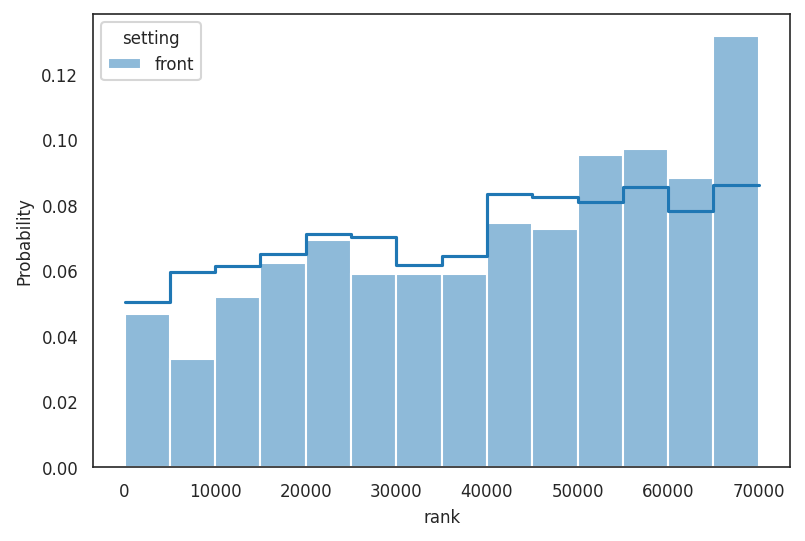

In [118]:
fig, axes = plt.subplots(1, 1, dpi=150)
binwidth = 5000

sns.histplot(origin_to_rank.reset_index(), x="rank", binwidth=binwidth, stat="probability", binrange=(0, 70_000), element="step", fill=False, ax=axes)
sns.histplot(failure_data[failure_data["setting"] == "front"], x="rank", hue="setting", stat="probability", binwidth=binwidth, binrange=(0, 70_000), ax=axes)

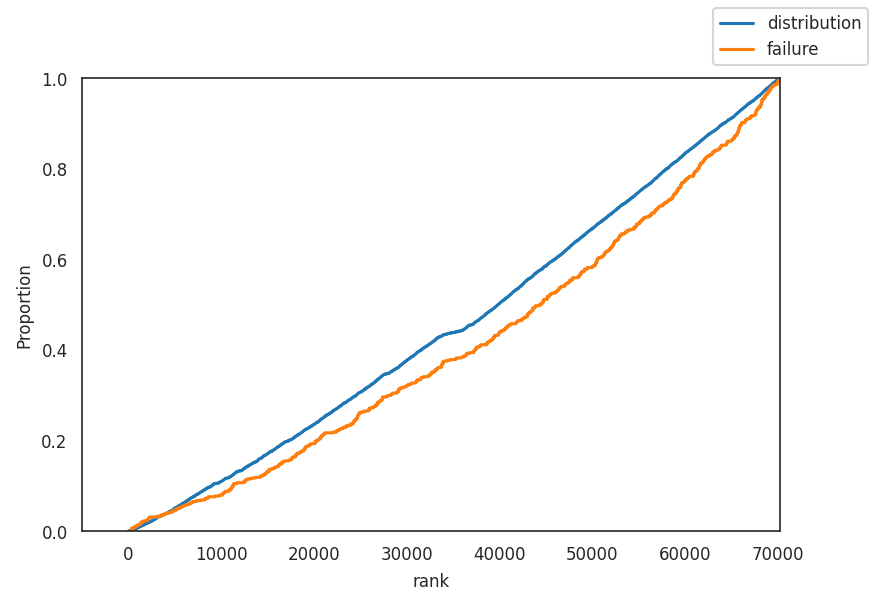

In [119]:
fig, axes = plt.subplots(1, 1, dpi=150)

front_data = failure_data[failure_data["setting"] == "front"]
otr_plot = origin_to_rank[origin_to_rank <= 70180]

sns.ecdfplot(otr_plot.reset_index(), x="rank", ax=axes, label="distribution")
sns.ecdfplot(front_data, x="rank", ax=axes, label="failure")

axes.set_xlim(right=70200)
# axes.set_xlim(0, 1000)
# axes.set_ylim(0, top=.01)

fig.legend()

<AxesSubplot:xlabel='rank', ylabel='Probability'>

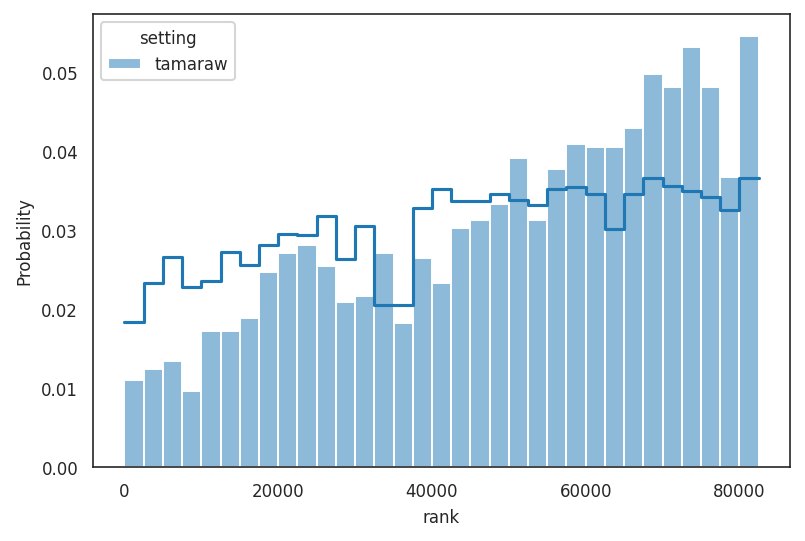

In [120]:
fig, axes = plt.subplots(1, 1, dpi=150)

sns.histplot(origin_to_rank.reset_index(), x="rank", binwidth=2500, stat="probability", binrange=(0, 82500), element="step", fill=False, ax=axes)
sns.histplot(failure_data[failure_data["setting"] == "tamaraw"], x="rank", hue="setting", stat="probability", binwidth=2500, binrange=(0, 82500), ax=axes)

In [121]:
server_versions = pd.read_csv(
    "../../results/version-scan/scan-results.csv", usecols=["rank", "server"],
)
server_versions


,rank,server
0,1,gws
1,2,ESF
2,3,Tengine
3,4,squid/3.5.24
4,5,BWS/1.1
...,...,...
99995,99996,cloudflare
99996,99997,Squarespace
99997,99998,nginx
99998,99999,NaN


In [122]:
failure_vers = failure_data.merge(server_versions, on="rank", how="left")
failure_vers

,setting,level_1,sample,origin,rank,server
0,front,0,results/webpage-graphs/graphs/10462.json,www.skyland.com.bd,68512.0,LiteSpeed
1,front,1,results/webpage-graphs/graphs/4559.json,www.defraglife.net,33979.0,LiteSpeed
2,front,2,results/webpage-graphs/graphs/9791.json,amzquiz.com,64957.0,LiteSpeed
3,front,3,results/webpage-graphs/graphs/2883.json,www.ntunhs.net,23045.0,cloudflare
4,front,4,results/webpage-graphs/graphs/5910.json,acarranza.com,43065.0,LiteSpeed
...,...,...,...,...,...,...
3584,tamaraw,3126,results/webpage-graphs/graphs/8528.json,todainfo.com,57801.0,cloudflare
3585,tamaraw,3127,results/webpage-graphs/graphs/3633.json,thegymking.com,28008.0,cloudflare
3586,tamaraw,3128,results/webpage-graphs/graphs/8444.json,gymdirect.com.au,57375.0,cloudflare
3587,tamaraw,3129,results/webpage-graphs/graphs/10235.json,outandaboutpv.com,67344.0,cloudflare


In [123]:
failure_vers[failure_vers["setting"] == "front"]["server"].value_counts()

LiteSpeed          393
cloudflare         138
nginx                8
DZ-HTTP              2
Google Frontend      2
UploadServer         1
Name: server, dtype: int64

In [124]:
queried = origin_to_rank.to_frame().merge(server_versions, on="rank", how="left")
queried = queried[queried["rank"] < 70000]
queried["server"].value_counts()

cloudflare                    11813
LiteSpeed                       677
gws                              94
GSE                              57
Google Frontend                  39
nginx                            36
sffe                             18
WPX CLOUD/FF                     10
ESF                               8
scaffolding on HTTPServer2        2
UploadServer                      2
DZ-HTTP                           2
gocache                           2
ufe                               2
nginx/1.16.1                      2
Apache                            2
Sucuri/Cloudproxy                 2
Artisanal bits                    1
Caddy                             1
envoy                             1
h2o/2.3.0-DEV@e44b7bd             1
jws/webrouter:bbaf2edc            1
DE VIL 0.1                        1
WPX CLOUD/FF02                    1
gtranslate                        1
PWS/8.3.1.0.8                     1
Google Tag Manager                1
geny.com                    

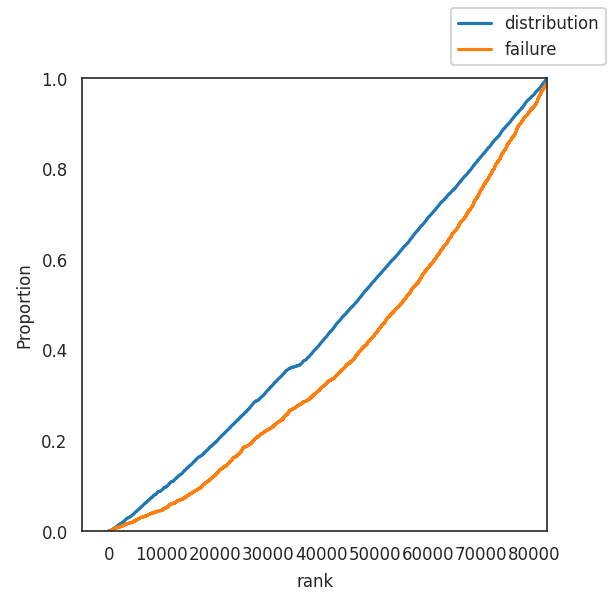

In [125]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

tamaraw_data = failure_data[failure_data["setting"] == "tamaraw"]
otr_plot = origin_to_rank[origin_to_rank <= 82500]

sns.ecdfplot(otr_plot.reset_index(), x="rank", ax=axes, label="distribution")
sns.ecdfplot(tamaraw_data, x="rank", ax=axes, label="failure")

axes.set_xlim(right=82500)
# axes.set_xlim(0, 1000)
# axes.set_ylim(0, top=.01)

fig.legend()

In [126]:
BINWIDTH = 2800  # 25 bins on range 0 to 70,000

bin_data = failure_data.copy()
bin_data["bins"] = pd.cut(failure_data["rank"], np.arange(0, 70001, BINWIDTH))
bin_data

# (bin_data["setting"] == "front").sum()

,setting,level_1,sample,origin,rank,bins
0,front,0,results/webpage-graphs/graphs/10462.json,www.skyland.com.bd,68512.0,"(67200, 70000]"
1,front,1,results/webpage-graphs/graphs/4559.json,www.defraglife.net,33979.0,"(33600, 36400]"
2,front,2,results/webpage-graphs/graphs/9791.json,amzquiz.com,64957.0,"(64400, 67200]"
3,front,3,results/webpage-graphs/graphs/2883.json,www.ntunhs.net,23045.0,"(22400, 25200]"
4,front,4,results/webpage-graphs/graphs/5910.json,acarranza.com,43065.0,"(42000, 44800]"
...,...,...,...,...,...,...
3584,tamaraw,3126,results/webpage-graphs/graphs/8528.json,todainfo.com,57801.0,"(56000, 58800]"
3585,tamaraw,3127,results/webpage-graphs/graphs/3633.json,thegymking.com,28008.0,"(28000, 30800]"
3586,tamaraw,3128,results/webpage-graphs/graphs/8444.json,gymdirect.com.au,57375.0,"(56000, 58800]"
3587,tamaraw,3129,results/webpage-graphs/graphs/10235.json,outandaboutpv.com,67344.0,"(67200, 70000]"


In [127]:
origin_to_rank_bins = origin_to_rank.to_frame()
origin_to_rank_bins["bins"] = pd.cut(origin_to_rank_bins["rank"], np.arange(0, 70001, BINWIDTH))
origin_to_rank_bins = origin_to_rank_bins.dropna()
origin_to_rank_bins

,rank,bins
origin,,
google.com,1,"(0, 2800]"
youtube.com,2,"(0, 2800]"
facebook.com,8,"(0, 2800]"
instagram.com,20,"(0, 2800]"
myshopify.com,32,"(0, 2800]"
...,...,...
xpressmoney.club,69977,"(67200, 70000]"
coolnewtabtheme.com,69985,"(67200, 70000]"
jwbni.com,69990,"(67200, 70000]"


In [128]:
counts = bin_data.groupby(["setting", "bins"], observed=True).size()
counts = counts.rename("failures").to_frame().reset_index().merge(
    origin_to_rank_bins.groupby("bins").size().rename("totals").to_frame(),
    on="bins", how="left"
)
counts["bin_fail_frac"] = counts["failures"] / counts["totals"]
counts

,setting,bins,failures,totals,bin_fail_frac
0,front,"(0, 2800]",18,333,0.054054
1,front,"(2800, 5600]",13,410,0.031707
2,front,"(5600, 8400]",11,461,0.023861
3,front,"(8400, 11200]",15,383,0.039164
4,front,"(11200, 14000]",12,439,0.027335
5,front,"(14000, 16800]",20,496,0.040323
6,front,"(16800, 19600]",22,441,0.049887
7,front,"(19600, 22400]",16,511,0.031311
8,front,"(22400, 25200]",26,504,0.051587
9,front,"(25200, 28000]",21,505,0.041584


Text(0, 0.5, 'Success rate')

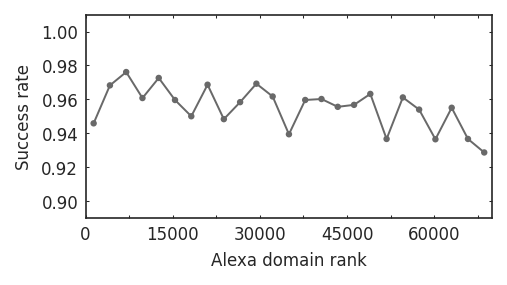

In [299]:
def _to_axis_space(value):
    return (value - BINWIDTH/2) / BINWIDTH

fig, axes = plt.subplots(figsize=(3.5, 1.8), dpi=150)
color = "dimgray"

plot_data = counts[counts["setting"] == "front"].copy()
plot_data["bin_succ"] = 1 - plot_data["bin_fail_frac"]

sns.pointplot(data=plot_data, x="bins", y="bin_succ", scale=.35, color=color)

ticks = np.arange(0, 75000, 7500, dtype=int)
axes.set_xticks([_to_axis_space(x) for x in ticks])
axes.set_xticklabels(["" if x % 1000 != 0 else x for x in ticks])
axes.tick_params(
    axis='both', which='both', bottom=True, top=True, right=True, left=True,
    direction="in", width=.5, length = 1.5,
)
axes.set_ylim(.89, 1.01)
axes.set_xlabel("Alexa domain rank")
axes.set_ylabel("Success rate")

Text(0.5, 0, 'Alexa domain rank')

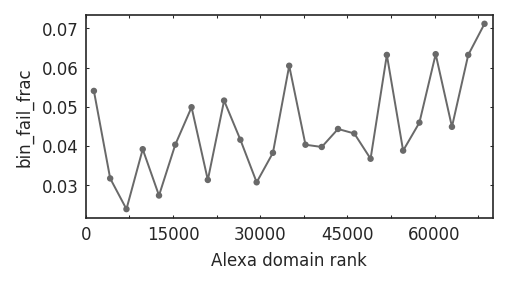

In [283]:
def _to_axis_space(value):
    return (value - BINWIDTH/2) / BINWIDTH

fig, axes = plt.subplots(figsize=(3.5, 1.8), dpi=150)
color = "dimgray"

plot_data = counts[counts["setting"] == "front"]

sns.pointplot(data=plot_data, x="bins", y="bin_fail_frac", scale=.35, color=color)

ticks = np.arange(0, 75000, 7500, dtype=int)
axes.set_xticks([_to_axis_space(x) for x in ticks])
axes.set_xticklabels(["" if x % 1000 != 0 else x for x in ticks])
axes.tick_params(
    axis='both', which='both', bottom=True, top=True, right=True, left=True,
    direction="in", width=.5, length = 1.5,
)
axes.set_xlabel("Alexa domain rank")

Text(0, 0.5, 'Failure probability')

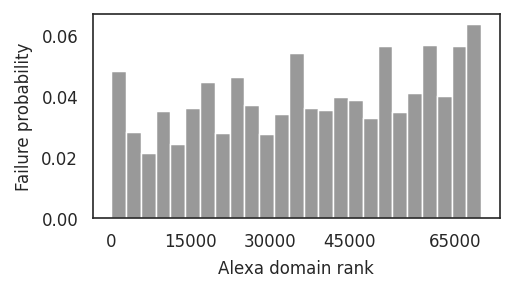

In [279]:
fig, axes = plt.subplots(figsize=(3.5, 1.8), dpi=150)

weights = (1 / origin_to_rank_bins.groupby("bins").size()).rename("weights").to_frame().reset_index()
# weights = (1 / counts[counts["setting"] == "front"].set_index("bins")["failures"]).rename("weights").to_frame().reset_index()

plot_data = failure_data[failure_data["setting"] == "front"].copy()
plot_data["bins"] = pd.cut(plot_data["rank"], np.arange(0, 70_001, BINWIDTH))
plot_data = plot_data.merge(weights, on="bins", how="left")

sns.histplot(plot_data, x="rank", stat="probability", weights="weights", binwidth=binwidth, binrange=(0, 70_000), ax=axes, color="black", alpha=.4)
# sns.histplot(plot_data, x="rank", stat="probability", element="poly", weights="weights", binwidth=binwidth, binrange=(0, 70_000), ax=axes, color="dimgrey", fill=False, linewidth=1)

axes.set_xticks([0, 15_000, 30_000, 45_000, 65000])
axes.set_xlabel("Alexa domain rank")
axes.set_ylabel("Failure probability")


In [66]:
final = pd.concat([front, tamaraw, undef], keys=["front", "tamaraw", "undefended"], names=["setting"]).rename("failures").to_frame().reset_index()
final = final.merge(bin_sizes.reset_index(), on="bins", how="left")
final["conditional"] = final["failures"]  * final["dist"]

for setting in ["front", "tamaraw", "undefended"]:
    total = final[final["setting"] == setting]["conditional"].sum()
    print(total)
    final[final["setting"] == setting]["conditional"] / total
final

NameError: name 'undef' is not defined

In [ ]:
sns.pointplot(data=final, x="bins", y="conditional", hue="setting")